In [127]:
# System modules
import os
import sys
from dotenv import load_dotenv
from time import time
import json

import requests
import pandas as pd

import logging
import requests
from hashlib import md5
import json

import pandas as pd


import plotly.graph_objects as go
import plotly.express as px

import nltk

# Append source directory to system path
src_path = os.path.abspath(os.path.join("../src"))
if src_path not in sys.path:
    sys.path.append(src_path)

# Helper functions
import data.helpers as data_helpers
import visualization.helpers as viz_helpers


load_dotenv()  # take environment variables from .env.

YELP_CLIENT_ID = os.getenv("YELP_CLIENT_ID")
YELP_API_KEY = os.getenv("YELP_API_KEY")


In [3]:
def yelp_business_search_by_location(
    location: str = "Paris", count: int = 200
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Get Yelp data from API.

    Params:
        location: str
        count: int

    Returns:
        json
    """
    headers = {
        "Authorization": f"Bearer {YELP_API_KEY}",
    }
    limit = 50

    businesses = pd.DataFrame()
    reviews = pd.DataFrame()
    photos = pd.DataFrame()
    for offset in range(0, count, limit):
        businesses_request = requests.get(
            "https://api.yelp.com/v3/businesses/search",
            headers=headers,
            params={
                "location": location,
                "limit": limit,
                "offset": offset,
            },
        )

        if businesses_request.status_code == 200:
            businesses_data = businesses_request.json()
            businesses = businesses.append(
                pd.DataFrame(businesses_data["businesses"]), ignore_index=True
            )

            for business in businesses_data["businesses"]:
                business_detail_request = requests.get(
                    f"https://api.yelp.com/v3/businesses/{business['id']}",
                    headers=headers,
                )
                if business_detail_request.status_code == 200:
                    business_detail_data = business_detail_request.json()
                    photos = photos.append(
                        pd.DataFrame(business_detail_data["photos"]),
                        ignore_index=True,
                    )
                else:
                    raise Exception(
                        f"Yelp API request failed with status code \
                             { business_detail_request.status_code }. \
                                 Response text: { business_detail_request.text }"
                    )

            for business in businesses_data["businesses"]:
                business_reviews_request = requests.get(
                    f"https://api.yelp.com/v3/businesses/{business['id']}/reviews",
                    headers=headers,
                )
                if business_reviews_request.status_code == 200:
                    business_reviews_data = business_reviews_request.json()
                    reviews = reviews.append(
                        pd.DataFrame(business_reviews_data["reviews"]),
                        ignore_index=True,
                    )
                else:
                    raise Exception(
                        f"Yelp API request failed with status code { business_reviews_request.status_code }. Response text: { business_reviews_request.text }"
                    )

        else:
            raise Exception(
                f"Yelp API request failed with status code { businesses_request.status_code }. Response text: { businesses_request.text }"
            )

    return businesses, reviews, photos


In [4]:
def get_yelp_data(
    locations: list[str] = [
        "Paris",
        "New York City",
        "Tokyo",
        "Rio de Janeiro",
        "Sydney",
    ],
    category: str = "restaurants",
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Get Yelp data from API.

    - iterate over the locations
        - build a GraphQL query to get the data
        - send the query to the Yelp API
        - parse the response
        - append to the dataframe
    - return the dataframes

    Params:
        locations: str[] (default: ["Paris"]) - List of Yelp locations to search
        category: str (default: "restaurants") - Yelp category (see https://www.yelp.com/developers/documentation/v3/all_category_list)

    Returns:
        businesses: pd.DataFrame - businesses data from Yelp API request
        reviews: pd.DataFrame - reviews data from Yelp API request
        photos: pd.DataFrame - photos data from Yelp API request
    """
    # businesses data (see https://www.yelp.com/developers/graphql/objects/business)
    businesses = pd.DataFrame(
        columns=[
            "business_alias",  # Unique Yelp alias of this business.
            "business_review_count",  # Total number of reviews for this business.
            "business_rating",  # Rating of the business, which is an average of the ratings of all reviews.
            "business_price",  # Price range of the business, from "$" to "$$$$" (inclusive).
            "business_city",  # City of this business.
            "business_state",  # ISO 3166-2 (with a few exceptions) state code of this business (see https://www.yelp.com/developers/documentation/v3/state_codes).
            "business_postal_code",  # Postal code of this business (see https://en.wikipedia.org/wiki/Postal_code)
            "business_country",  # ISO 3166-1 alpha-2 country code of this business.
            "business_latitude",  # Latitude of the business.
            "business_longitude",  # Longitude of the business.
            "business_categories",  # List of categories the business belongs to.
            "business_parent_categories",  # List of parent categories the business belongs to.
        ]
    )
    reviews = pd.DataFrame(
        columns=[
            "business_alias",  # Unique Yelp alias of the business.
            "review_text",  # Text excerpt of this review.
            "review_rating",  # Rating of this review.
        ]
    )
    photos = pd.DataFrame(
        columns=[
            "business_alias",  # Unique Yelp alias of the business.
            "photo_url",  # URL of the photo.
        ]
    )

    # Yelp's GraphQL endpoint
    url = "https://api.yelp.com/v3/graphql"
    # Request headers
    headers = {
        "Authorization": f"Bearer {YELP_API_KEY}",
        "Content-Type": "application/graphql",
    }
    count = 200  # Yelp's GraphQL API returns a maximum of 240 total results
    limit = 50  # Yelp's GraphQL API returns a maximum of 50 results per request

    for location in locations:
        for offset in range(0, count, limit):
            # Build the GraphQL query
            query = f'{{\n\
        search(categories: "{ category }", location: "{ location }", offset: { offset }, limit:  { limit }) {{\n\
            business {{\n\
                alias\n\
                review_count\n\
                rating\n\
                price\n\
                location {{\n\
                    city\n\
                    state\n\
                    postal_code\n\
                    country\n\
                }}\n\
                coordinates {{\n\
                    latitude\n\
                    longitude\n\
                }}\n\
                categories {{\n\
                    alias\n\
                    parent_categories {{\n\
                        alias\n\
                    }}\n\
                }}\n\
                photos\n\
                reviews {{\n\
                    text\n\
                    rating\n\
                }}\n\
            }}\n\
        }}\n\
    }}'
            # Send the query to the Yelp API
            response = requests.post(url, headers=headers, data=query)
            # Parse the response
            if not response.status_code == 200:
                raise Exception(
                    f"Yelp API request failed with status code { response.status_code }. Response text: { response.text }"
                )

            # Parse the response
            data = response.json()

            if "errors" in data:
                raise Exception(
                    f"Yelp API request failed with errors: { data['errors'] }"
                )

            for business in (
                data.get("data", {}).get("search", {}).get("business", [])
            ):
                # Add the business data to the dataframe
                businesses = businesses.append(
                    {
                        "business_alias": business.get("alias"),
                        "business_review_count": business.get("review_count"),
                        "business_rating": business.get("rating"),
                        "business_price": len(  # count the number of characters ($, €, ...)
                            business.get("price")
                        )
                        if business.get("price") is not None
                        else 0,
                        "business_city": business.get("location", {}).get(
                            "city"
                        ),
                        "business_state": business.get("location", {}).get(
                            "state"
                        ),
                        "business_postal_code": business.get(
                            "location", {}
                        ).get("postal_code"),
                        "business_country": business.get("location", {}).get(
                            "country"
                        ),
                        "business_latitude": business.get(
                            "coordinates", {}
                        ).get("latitude"),
                        "business_longitude": business.get(
                            "coordinates", {}
                        ).get("longitude"),
                        "business_categories": json.dumps(
                            list(
                                set(  # keep unique values
                                    [
                                        cat.get("alias")
                                        for cat in business.get(
                                            "categories", []
                                        )
                                    ]
                                )
                            )
                        ),
                        "business_parent_categories": json.dumps(
                            list(
                                set(  # keep unique values
                                    [
                                        parent_cat.get("alias")
                                        for cat in business.get(
                                            "categories", []
                                        )
                                        for parent_cat in cat.get(
                                            "parent_categories", []
                                        )
                                    ]
                                )
                            )
                        ),
                    },
                    ignore_index=True,
                )

                for photo in business.get("photos", []) or []:
                    # Add the photo data to the dataframe
                    photos = photos.append(
                        {
                            "business_alias": business.get("alias"),
                            "photo_url": photo,
                        },
                        ignore_index=True,
                    )

                for review in business.get("reviews", []) or []:
                    # Add the review data to the dataframe
                    reviews = reviews.append(
                        {
                            "business_alias": business.get("alias"),
                            "review_text": review.get("text"),
                            "review_rating": review.get("rating"),
                        },
                        ignore_index=True,
                    )

    # Return the dataframes
    return businesses, reviews, photos


def download_photos(
    photos: pd.DataFrame,
    target_path: str,
) -> None:
    # Check if content path exists
    if not os.path.exists(target_path):
        logging.info(f"Creating {target_path}")
        os.makedirs(target_path)

    for photo in photos.itertuples(index=False):
        file_name = f"{ photo.business_alias }_{ md5(photo.photo_url.encode('utf-8')).hexdigest() }.jpg"
        file_path = os.path.join(target_path, file_name)

        if not os.path.exists(file_path):
            request = requests.get(photo.photo_url)
            if not 200 == request.status_code:
                logging.warning(
                    f"Photo URL : { photo.photo_url }\nYelp API request failed with status code: { request.status_code }.\nResponse text: { request.text }"
                )
                continue

            photo_data = request.content
            with open(file_path, "wb") as f:
                f.write(photo_data)


In [5]:
data_path = "../data/raw/"
businesses_csv_path = os.path.join(data_path, "businesses.csv")
reviews_csv_path = os.path.join(data_path, "reviews.csv")
photos_csv_path = os.path.join(data_path, "photos.csv")

if not os.path.exists(data_path):
    logging.info(f"Creating {data_path}")
    os.makedirs(data_path)

if (
    os.path.exists(businesses_csv_path)
    and os.path.exists(reviews_csv_path)
    and os.path.exists(photos_csv_path)
):
    logging.info(f"Data already downloaded")
    businesses_df = pd.read_csv(businesses_csv_path)
    reviews_df = pd.read_csv(reviews_csv_path)
    photos_df = pd.read_csv(photos_csv_path)
else:
    logging.info("Saving data")
    businesses_df, reviews_df, photos_df = get_yelp_data()

    businesses_df.to_csv(businesses_csv_path, index=False)
    reviews_df.to_csv(reviews_csv_path, index=False)
    photos_df.to_csv(photos_csv_path, index=False)


# Fix dtypes
businesses_df["business_alias"] = businesses_df["business_alias"].astype(str)
businesses_df["business_review_count"] = businesses_df[
    "business_review_count"
].astype(int)
businesses_df["business_rating"] = businesses_df["business_rating"].astype(
    float
)
businesses_df["business_price"] = businesses_df["business_price"].astype(int)
businesses_df["business_city"] = businesses_df["business_city"].astype(str)
businesses_df["business_state"] = businesses_df["business_state"].astype(str)
businesses_df["business_postal_code"] = businesses_df[
    "business_postal_code"
].astype(str)
businesses_df["business_country"] = businesses_df["business_country"].astype(
    str
)
businesses_df["business_latitude"] = businesses_df["business_latitude"].astype(
    float
)
businesses_df["business_longitude"] = businesses_df[
    "business_longitude"
].astype(float)
businesses_df["business_categories"] = businesses_df[
    "business_categories"
].astype(str)
businesses_df["business_parent_categories"] = businesses_df[
    "business_parent_categories"
].astype(str)

reviews_df["business_alias"] = reviews_df["business_alias"].astype(str)
reviews_df["review_text"] = reviews_df["review_text"].astype(str)
reviews_df["review_rating"] = reviews_df["review_rating"].astype(float)

photos_df["business_alias"] = photos_df["business_alias"].astype(str)
photos_df["photo_url"] = photos_df["photo_url"].astype(str)


# Reduce memory usage
businesses_df = data_helpers.reduce_dataframe_memory_usage(businesses_df)
reviews_df = data_helpers.reduce_dataframe_memory_usage(reviews_df)
photos_df = data_helpers.reduce_dataframe_memory_usage(photos_df)


In [6]:
businesses_df.head()


,business_alias,business_review_count,business_rating,business_price,business_city,business_state,business_postal_code,business_country,business_latitude,business_longitude,business_categories,business_parent_categories
0,le-comptoir-de-la-gastronomie-paris,1107,4.5,2,Paris,75,75001,FR,48.864517,2.345402,"[""french""]","[""restaurants""]"
1,l-as-du-fallafel-paris,1810,4.5,1,Paris,75,75004,FR,48.857498,2.359080,"[""kosher"", ""falafel"", ""sandwiches""]","[""restaurants"", ""mediterranean""]"
2,angelina-paris,1347,4.0,3,Paris,75,75001,FR,48.865093,2.328464,"[""tea"", ""cakeshop"", ""breakfast_brunch""]","[""restaurants"", ""food""]"
3,l-avant-comptoir-paris-3,612,4.5,2,Paris,75,75006,FR,48.852020,2.338800,"[""wine_bars"", ""tapas""]","[""bars"", ""restaurants""]"
4,la-coïncidence-paris-4,493,4.5,2,Paris,75,75116,FR,48.868107,2.284365,"[""french""]","[""restaurants""]"


In [7]:
businesses_df.describe(include="all")


,business_alias,business_review_count,business_rating,business_price,business_city,business_state,business_postal_code,business_country,business_latitude,business_longitude,business_categories,business_parent_categories
count,1000,1000.000000,1000.000000,1000.000000,1000,1000,1000,1000,1000.000000,1000.000000,1000,1000
unique,1000,NaN,NaN,NaN,40,6,301,5,NaN,NaN,530,50
top,le-comptoir-de-la-gastronomie-paris,NaN,NaN,NaN,Paris,13,2000,AU,NaN,NaN,"[""french""]","[""restaurants""]"
freq,1,NaN,NaN,NaN,200,200,139,200,NaN,NaN,56,551
mean,NaN,529.395000,4.270500,2.144000,NaN,NaN,NaN,NaN,13.688472,35.219700,NaN,NaN
std,NaN,1134.869631,0.353135,0.897814,NaN,NaN,NaN,NaN,34.823799,93.358452,NaN,NaN
min,NaN,6.000000,3.000000,0.000000,NaN,NaN,NaN,NaN,-33.897026,-74.016022,NaN,NaN
25%,NaN,30.000000,4.000000,2.000000,NaN,NaN,NaN,NaN,-22.983292,-43.218462,NaN,NaN
50%,NaN,71.000000,4.500000,2.000000,NaN,NaN,NaN,NaN,35.673141,2.340317,NaN,NaN
75%,NaN,265.750000,4.500000,3.000000,NaN,NaN,NaN,NaN,40.751259,139.770420,NaN,NaN


In [8]:
reviews_df.head()


,business_alias,review_text,review_rating
0,le-comptoir-de-la-gastronomie-paris,This review is from our 2019 trip. Shame on m...,5.0
1,le-comptoir-de-la-gastronomie-paris,This place def lives up the hype. Best French...,5.0
2,le-comptoir-de-la-gastronomie-paris,"While planning a friends trip to Paris, I came...",5.0
3,l-as-du-fallafel-paris,This is the best falafel sandwich I have ever ...,5.0
4,l-as-du-fallafel-paris,IMO this is a must try in Paris. Located in ...,5.0


In [9]:
reviews_df.describe(include="all")


,business_alias,review_text,review_rating
count,2928,2928,2928.000000
unique,990,2928,NaN
top,le-comptoir-de-la-gastronomie-paris,This review is from our 2019 trip. Shame on m...,NaN
freq,3,1,NaN
mean,NaN,NaN,4.396516
std,NaN,NaN,0.904879
min,NaN,NaN,1.000000
25%,NaN,NaN,4.000000
50%,NaN,NaN,5.000000
75%,NaN,NaN,5.000000


In [10]:
photos_df.head()


,business_alias,photo_url
0,le-comptoir-de-la-gastronomie-paris,https://s3-media2.fl.yelpcdn.com/bphoto/Je6THJ...
1,l-as-du-fallafel-paris,https://s3-media2.fl.yelpcdn.com/bphoto/wdIhzK...
2,angelina-paris,https://s3-media3.fl.yelpcdn.com/bphoto/DPM5TB...
3,l-avant-comptoir-paris-3,https://s3-media3.fl.yelpcdn.com/bphoto/mVwgxg...
4,la-coïncidence-paris-4,https://s3-media1.fl.yelpcdn.com/bphoto/QdrAgE...


In [11]:
photos_df.describe(include="all")


,business_alias,photo_url
count,1000,1000
unique,1000,1000
top,le-comptoir-de-la-gastronomie-paris,https://s3-media2.fl.yelpcdn.com/bphoto/Je6THJ...
freq,1,1


In [12]:
download_photos(photos_df, target_path="../data/raw/photos/")


Yelp API request failed with status code: 403.
Response text: <?xml version="1.0" encoding="UTF-8"?>
<Error><Code>AccessDenied</Code><Message>Access Denied</Message><RequestId>829ZHT7J0R6CKV5S</RequestId><HostId>QdkT75IL7TO+afm7TqIcyolUwRz6Ws9HOXlCIAIicEkLbcS+fnQjjIdTkPs8Ycf70A1i0d2rauQ=</HostId></Error>


In [13]:
def one_hot_encode_list_variables(
    df: pd.DataFrame,
    columns: list[str],
) -> pd.DataFrame:
    """One-hot encode list variables.
    See : https://cmpoi.medium.com/a-quick-tutorial-to-encode-list-variables-125ba4040325

    - for each list variable
        - decode JSON values to list
        - make a dataframe of one-hot encoded values
        - append to original dataframe

    Args:
        df (pd.DataFrame): dataframe to encode
        columns (list[str]): list of columns to encode

    Raises:
        Exception: columns values should be (JSON encoded) lists of strings

    Returns:
        pd.DataFrame:  dataframe with encoded columns
    """
    df = df.copy()
    for col in columns:
        if not isinstance(df[col][0], list):
            df[col] = df[col].replace(
                "[]", "null"
            )  # replace empty list with null
            df[col] = df[col].apply(json.loads)  # convert string to list

        if not isinstance(df[col][0], list):
            raise Exception(f"{col} is not a list")

        categories_df = (
            pd.get_dummies(
                pd.DataFrame(
                    [
                        x
                        if x is not None
                        else ["__EMPTY__"]  # replace None with empty list
                        for x in df[col].tolist()
                    ]
                ).stack(),
            )
            .groupby(level=0)
            .sum()
        ).drop(
            columns="__EMPTY__", errors="ignore"
        )  # remove empty list

        df = pd.concat([df, categories_df], axis=1)

    return df


df = one_hot_encode_list_variables(
    businesses_df, ["business_categories", "business_parent_categories"]
)


In [14]:
df.describe(include="all")


,business_alias,business_review_count,business_rating,business_price,business_city,business_state,business_postal_code,business_country,business_latitude,business_longitude,...,jpsweets,latin,media,mediterranean,mexican,mideastern,nightlife,publicservicesgovt,restaurants,shopping
count,1000,1000.000000,1000.000000,1000.000000,1000,1000,1000,1000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
unique,1000,NaN,NaN,NaN,40,6,301,5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,le-comptoir-de-la-gastronomie-paris,NaN,NaN,NaN,Paris,13,2000,AU,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,200,200,139,200,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,529.395000,4.270500,2.144000,NaN,NaN,NaN,NaN,13.688472,35.219700,...,0.001000,0.001000,0.003000,0.003000,0.004000,0.003000,0.060000,0.001000,0.87900,0.002000
std,NaN,1134.869631,0.353135,0.897814,NaN,NaN,NaN,NaN,34.823799,93.358452,...,0.031623,0.031623,0.054717,0.054717,0.063151,0.054717,0.237606,0.031623,0.32629,0.044699
min,NaN,6.000000,3.000000,0.000000,NaN,NaN,NaN,NaN,-33.897026,-74.016022,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,NaN,30.000000,4.000000,2.000000,NaN,NaN,NaN,NaN,-22.983292,-43.218462,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000
50%,NaN,71.000000,4.500000,2.000000,NaN,NaN,NaN,NaN,35.673141,2.340317,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000
75%,NaN,265.750000,4.500000,3.000000,NaN,NaN,NaN,NaN,40.751259,139.770420,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000


## Commentaires clients


In [15]:
fig = px.histogram(reviews_df, x="review_rating", marginal="box")
fig.show()


In [16]:
from sklearn.model_selection import train_test_split


X = reviews_df["review_text"]
y = reviews_df["review_rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


## Rating Regression


In [98]:
from sklearn.feature_extraction.text import CountVectorizer


vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


# from sklearn.preprocessing import StandardScaler


# scaler = StandardScaler().fit(X_train_vec.toarray())

# X_train_std = scaler.transform(X_train_vec.toarray())
# X_test_std = scaler.transform(X_test_vec.toarray())


# from imblearn.under_sampling import ClusterCentroids
# from imblearn.combine import SMOTEENN
# from imblearn.over_sampling import SMOTE


# sampler = SMOTE(sampling_strategy="all", n_jobs=-1, random_state=42)
# X_train_res, y_train_res = sampler.fit_resample(X_train_vec, y_train)

# X_new = pd.DataFrame(X_resampled).append(pd.DataFrame(X_resampled))
# y_new = pd.DataFrame(y_resampled).append(pd.DataFrame(y_train))


from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer


from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, PassiveAggressiveRegressor, SGDRegressor, Ridge, RidgeCV, Lars, LarsCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, LassoLars, LassoLarsCV, OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV, BayesianRidge, ARDRegression, HuberRegressor, TheilSenRegressor, PassiveAggressiveRegressor, SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
import numpy as np

from sklearn.metrics import median_absolute_error, r2_score

results=[]
for model in [
    DummyRegressor(),
    # LinearRegression(), 
    # BayesianRidge(),
    # PassiveAggressiveRegressor(),
    # SGDRegressor(),
    # Ridge(),
    # RidgeCV(),
    # Lars(),
    # LarsCV(),
    # Lasso(),
    # LassoCV(),
    # ElasticNet(),
    ElasticNetCV(),
    # LassoLars(),
    # LassoLarsCV(),
    # OrthogonalMatchingPursuit(),
    # OrthogonalMatchingPursuitCV(),
    # BayesianRidge(),
    # ARDRegression(),
    # HuberRegressor(),
    # TheilSenRegressor(),
    # PassiveAggressiveRegressor(),
    # SGDRegressor(),
    # KernelRidge(),
    # SVR(),
    # KNeighborsRegressor(),
    # DecisionTreeRegressor(),
    # RandomForestRegressor(),
    # GradientBoostingRegressor(),
    # LGBMRegressor(),
]:
    print()
    print(f"{model.__class__.__name__}")

    reg = TransformedTargetRegressor(
        regressor=model,
        # transformer=QuantileTransformer(),
    ).fit(X_train_vec.astype("float"), y_train.astype("float"))
    y_pred = reg.predict(X_test_vec.astype("float"))

    results.append(
        {
            "model": model.__class__.__name__,
            "r2_score": r2_score(y_test, y_pred),
            "median_absolute_error": median_absolute_error(y_test, y_pred),
        }
    )

    print(f"R² = {round(r2_score(y_test, y_pred), 3)} / MAE = {round(median_absolute_error(y_test, y_pred), 3)}")
    print()


print(
    pd.DataFrame(results).sort_values(
        by=["r2_score", "median_absolute_error"],
        ascending=[False, True],
    )
)



DummyRegressor
R² = -0.001 / MAE = 0.611


ElasticNetCV
R² = 0.142 / MAE = 0.495

            model  r2_score  median_absolute_error
1    ElasticNetCV  0.141958               0.494658
0  DummyRegressor -0.001158               0.611111


In [128]:
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize, pos_tag

import spacy

import string

nltk.download("stopwords")
nltk.download("wordnet")
stopwords = set(stopwords.words("english"))

nlp = spacy.load("en_core_web_sm")


def pos_tagger(nltk_tag):
    if nltk_tag.startswith("J"):
        return wordnet.ADJ
    elif nltk_tag.startswith("V"):
        return wordnet.VERB
    elif nltk_tag.startswith("N"):
        return wordnet.NOUN
    elif nltk_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


results = []
for vectorizer_name, vectorizer in [
    ("CountVectorizer", CountVectorizer()),
    (
        "CountVectorizer + strip_accents + lowercase",
        CountVectorizer(
            strip_accents="unicode",
            lowercase=True,
        ),
    ),
    (
        "CountVectorizer + strip_accents + lowercase + stop_words",
        CountVectorizer(
            strip_accents="unicode",
            lowercase=True,
            stop_words=stopwords,
        ),
    ),
    (
        "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df",
        CountVectorizer(
            strip_accents="unicode",
            lowercase=True,
            stop_words=stopwords,
            max_df=0.9,
            min_df=0.01,
        ),
    ),
    (
        "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams",
        CountVectorizer(
            strip_accents="unicode",
            lowercase=True,
            stop_words=stopwords,
            max_df=0.9,
            min_df=0.01,
            ngram_range=(1, 3),
        ),
    ),
    (
        "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams + PorterStemmer",
        CountVectorizer(
            strip_accents="unicode",
            lowercase=True,
            stop_words=stopwords,
            max_df=0.9,
            min_df=0.01,
            ngram_range=(1, 3),
            tokenizer=lambda text: [
                PorterStemmer().stem(token).lower()
                for token in word_tokenize(text)
                if token.isalpha() and token.lower() not in stopwords
            ],
        ),
    ),
    (
        "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams + WordNetLemmatizer",
        CountVectorizer(
            strip_accents="unicode",
            lowercase=True,
            stop_words=stopwords,
            max_df=0.9,
            min_df=0.01,
            ngram_range=(1, 3),
            tokenizer=lambda text: [
                WordNetLemmatizer().lemmatize(token, pos_tagger(pos)).lower()
                for token, pos in nltk.pos_tag(nltk.word_tokenize(text))
                if token.isalpha() and token.lower() not in stopwords
            ],
        ),
    ),
    (
        "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams + SpaCy",
        CountVectorizer(
            strip_accents="unicode",
            lowercase=True,
            stop_words=stopwords,
            max_df=0.9,
            min_df=0.01,
            ngram_range=(1, 3),
            tokenizer=lambda text: [
                token.lemma_.lower()
                for token in nlp(text)
                if token.is_alpha and not token.is_stop
            ],
        ),
    ),
    (
        "TfidfVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams + SpaCy",
        TfidfVectorizer(
            strip_accents="unicode",
            lowercase=True,
            stop_words=stopwords,
            max_df=0.9,
            min_df=0.01,
            ngram_range=(1, 3),
            tokenizer=lambda text: [
                token.lemma_.lower()
                for token in nlp(text)
                if token.is_alpha and not token.is_stop
            ],
        ),
    ),
]:
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # viz_helpers.plot_pca_2d(
    #     pd.DataFrame(X_train_vec.todense(), columns=vectorizer.get_feature_names()),
    #     y_train,
    # )

    words_count = pd.Series(
        X_train_vec.sum(axis=0).tolist()[0],
        index=vectorizer.get_feature_names(),
    )

    top_20_count = words_count.sort_values(ascending=False).head(20)

    fig = px.bar(
        top_20_count,
        x=top_20_count.index,
        y=top_20_count.values,
        labels={"x": "Word", "y": "Count"},
        title=f"{vectorizer_name} : Top 20 frequent words in reviews (vocabulary = {len(words_count)} words)",
        color=top_20_count.values,
    )
    fig.show()

    reg = ElasticNetCV(random_state=42, n_jobs=-1).fit(X_train_vec, y_train)
    coefs = pd.Series(reg.coef_, index=vectorizer.get_feature_names())

    top_20_coefs = coefs.nlargest(10).append(coefs.nsmallest(10)).sort_values()

    fig = px.bar(
        top_20_coefs,
        x=top_20_coefs.index,
        y=top_20_coefs.values,
        labels={"x": "Word", "y": "Count"},
        title=f"{vectorizer_name} : Top 20 important words in reviews (vocabulary = {len(words_count)} words)",
        color=top_20_coefs.values,
    )
    fig.show()

    y_pred = reg.predict(X_test_vec)

    fig = px.box(
        x=y_test,
        y=y_pred,
        labels={"x": "Actual", "y": "Predicted"},
        title=f"{vectorizer_name} : Actual vs Predicted / R² = {round(r2_score(y_test, y_pred), 3)} / MAE = {round(median_absolute_error(y_test, y_pred), 3)}",
        color=y_test,
    )
    fig.show()

    results.append(
        {
            "vectorizer": vectorizer_name,
            "vocabulary_size": len(words_count),
            "r2_score": round(r2_score(y_test, y_pred), 3),
            "median_absolute_error": round(
                median_absolute_error(y_test, y_pred), 3
            ),
        }
    )

    print()
    print(f"{vectorizer_name}")
    print(
        f"vocabulary = {len(words_count)} words / R² = {round(r2_score(y_test, y_pred), 3)} / MAE = {round(median_absolute_error(y_test, y_pred), 3)}"
    )
    print()

print(
    pd.DataFrame(results).sort_values(
        by=["r2_score", "median_absolute_error"],
        ascending=[False, True],
    )
)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/clement/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/clement/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


KeyboardInterrupt: 

# Sentiment Classification


In [109]:

y_train_bi = [0 if x < 5 else 1 for x in y_train]
y_test_bi = [0 if x < 5 else 1 for x in y_test]


In [110]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)



from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

results=[]
for model in [
    DummyClassifier(),
    LogisticRegressionCV(max_iter=1000), 
    RidgeClassifierCV(),
    SGDClassifier(),
    SVC(),
    KNeighborsClassifier(),
    MLPClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    LGBMClassifier(),
]:
    print()
    print(f"{model.__class__.__name__}")

    cls = model.fit(X_train_vec.astype("float"), y_train_bi)
    y_pred = cls.predict(X_test_vec.astype("float"))

    results.append(
        {
            "model": model.__class__.__name__,
            "accuracy_score": accuracy_score(y_test_bi, y_pred),
            "precision_score": precision_score(y_test_bi, y_pred),
            "recall_score": recall_score(y_test_bi, y_pred),
            "f1_score": f1_score(y_test_bi, y_pred),
            "roc_auc_score": roc_auc_score(y_test_bi, y_pred),
        }
    )

    print(f"accuracy_score = {round(accuracy_score(y_test_bi, y_pred), 3)} / precision_score = {round(precision_score(y_test_bi, y_pred), 3)} / recall_score = {round(recall_score(y_test_bi, y_pred), 3)} / f1_score = {round(f1_score(y_test_bi, y_pred), 3)} / roc_auc_score = {round(roc_auc_score(y_test_bi, y_pred), 3)}")
    print()


print(
    pd.DataFrame(results).sort_values(
        by=["roc_auc_score", "f1_score"],
        ascending=[False, False],
    )
)



DummyClassifier
accuracy_score = 0.615 / precision_score = 0.615 / recall_score = 1.0 / f1_score = 0.761 / roc_auc_score = 0.5


LogisticRegressionCV
accuracy_score = 0.656 / precision_score = 0.686 / recall_score = 0.811 / f1_score = 0.743 / roc_auc_score = 0.609


RidgeClassifierCV
accuracy_score = 0.65 / precision_score = 0.689 / recall_score = 0.784 / f1_score = 0.734 / roc_auc_score = 0.61


SGDClassifier
accuracy_score = 0.628 / precision_score = 0.691 / recall_score = 0.716 / f1_score = 0.703 / roc_auc_score = 0.602


SVC
accuracy_score = 0.649 / precision_score = 0.663 / recall_score = 0.873 / f1_score = 0.754 / roc_auc_score = 0.582


KNeighborsClassifier
accuracy_score = 0.602 / precision_score = 0.647 / recall_score = 0.776 / f1_score = 0.706 / roc_auc_score = 0.551


MLPClassifier
accuracy_score = 0.624 / precision_score = 0.685 / recall_score = 0.72 / f1_score = 0.702 / roc_auc_score = 0.596


DecisionTreeClassifier
accuracy_score = 0.577 / precision_score = 0.659 / recal

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/clement/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/clement/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


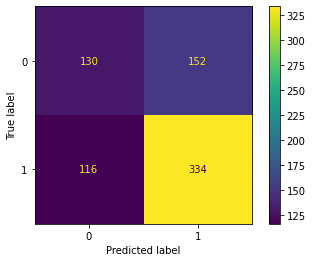


CountVectorizer
vocabulary = 5541 words / accuracy_score = 0.634 / precision_score = 0.687 / recall_score = 0.742 / f1_score = 0.714 / roc_auc_score = 0.602



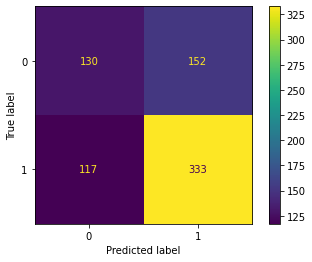


CountVectorizer + strip_accents + lowercase
vocabulary = 5523 words / accuracy_score = 0.633 / precision_score = 0.687 / recall_score = 0.74 / f1_score = 0.712 / roc_auc_score = 0.6



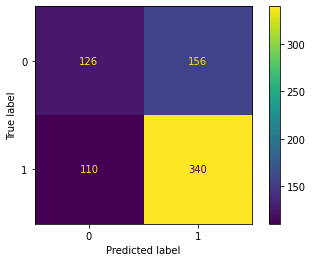


CountVectorizer + strip_accents + lowercase + stop_words
vocabulary = 5389 words / accuracy_score = 0.637 / precision_score = 0.685 / recall_score = 0.756 / f1_score = 0.719 / roc_auc_score = 0.601



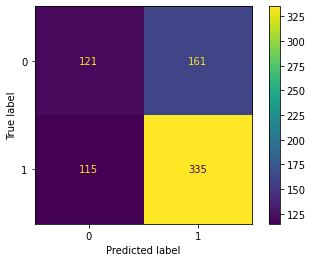


CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df
vocabulary = 283 words / accuracy_score = 0.623 / precision_score = 0.675 / recall_score = 0.744 / f1_score = 0.708 / roc_auc_score = 0.587



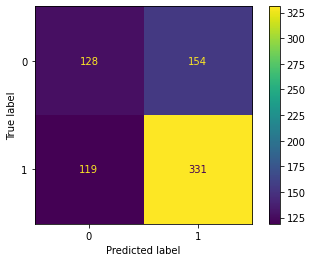


CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams
vocabulary = 291 words / accuracy_score = 0.627 / precision_score = 0.682 / recall_score = 0.736 / f1_score = 0.708 / roc_auc_score = 0.595



/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'sha', 'wo', 'would'] not in stop_words.



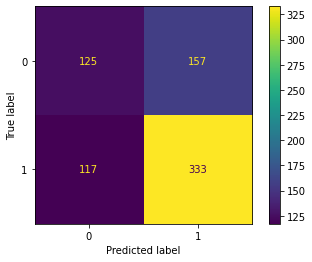


CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams + PorterStemmer
vocabulary = 294 words / accuracy_score = 0.626 / precision_score = 0.68 / recall_score = 0.74 / f1_score = 0.709 / roc_auc_score = 0.592



/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'sha', 'wo', 'would'] not in stop_words.



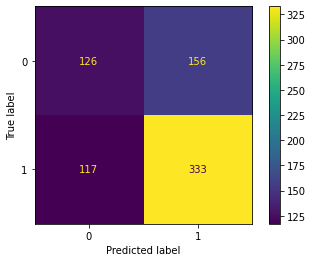


CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams + WordNetLemmatizer
vocabulary = 286 words / accuracy_score = 0.627 / precision_score = 0.681 / recall_score = 0.74 / f1_score = 0.709 / roc_auc_score = 0.593



/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['need', 'shall', 'win'] not in stop_words.



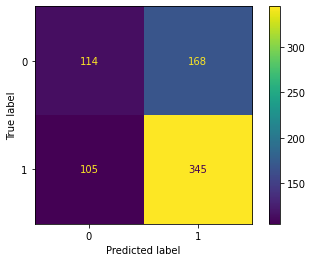


CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams + SpaCy
vocabulary = 248 words / accuracy_score = 0.627 / precision_score = 0.673 / recall_score = 0.767 / f1_score = 0.717 / roc_auc_score = 0.585



/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['need', 'shall', 'win'] not in stop_words.



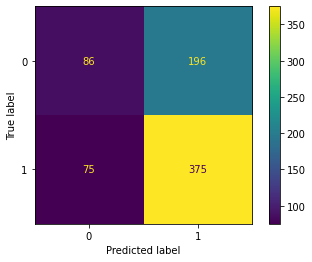


TfidfVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams + SpaCy
vocabulary = 248 words / accuracy_score = 0.63 / precision_score = 0.657 / recall_score = 0.833 / f1_score = 0.735 / roc_auc_score = 0.569

                                          vectorizer  vocabulary_size  \
0                                    CountVectorizer             5541   
2  CountVectorizer + strip_accents + lowercase + ...             5389   
1        CountVectorizer + strip_accents + lowercase             5523   
4  CountVectorizer + strip_accents + lowercase + ...              291   
6  CountVectorizer + strip_accents + lowercase + ...              286   
5  CountVectorizer + strip_accents + lowercase + ...              294   
3  CountVectorizer + strip_accents + lowercase + ...              283   
7  CountVectorizer + strip_accents + lowercase + ...              248   
8  TfidfVectorizer + strip_accents + lowercase + ...              248   

   accuracy_score  precision_score  rec

In [118]:
import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize, pos_tag

import spacy

import string

nltk.download("stopwords")
nltk.download("wordnet")
stopwords = set(stopwords.words("english"))

nlp = spacy.load("en_core_web_sm")


def pos_tagger(nltk_tag):
    if nltk_tag.startswith("J"):
        return wordnet.ADJ
    elif nltk_tag.startswith("V"):
        return wordnet.VERB
    elif nltk_tag.startswith("N"):
        return wordnet.NOUN
    elif nltk_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


results = []
for vectorizer_name, vectorizer in [
    ("CountVectorizer", CountVectorizer()),
    (
        "CountVectorizer + strip_accents + lowercase",
        CountVectorizer(
            strip_accents="unicode",
            lowercase=True,
        ),
    ),
    (
        "CountVectorizer + strip_accents + lowercase + stop_words",
        CountVectorizer(
            strip_accents="unicode",
            lowercase=True,
            stop_words=stopwords,
        ),
    ),
    (
        "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df",
        CountVectorizer(
            strip_accents="unicode",
            lowercase=True,
            stop_words=stopwords,
            max_df=0.9,
            min_df=0.01,
        ),
    ),
    (
        "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams",
        CountVectorizer(
            strip_accents="unicode",
            lowercase=True,
            stop_words=stopwords,
            max_df=0.9,
            min_df=0.01,
            ngram_range=(1, 3),
        ),
    ),
    (
        "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams + PorterStemmer",
        CountVectorizer(
            strip_accents="unicode",
            lowercase=True,
            stop_words=stopwords,
            max_df=0.9,
            min_df=0.01,
            ngram_range=(1, 3),
            tokenizer=lambda text: [
                PorterStemmer().stem(token).lower()
                for token in word_tokenize(text)
                if token.isalpha() and token.lower() not in stopwords
            ],
        ),
    ),
    (
        "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams + WordNetLemmatizer",
        CountVectorizer(
            strip_accents="unicode",
            lowercase=True,
            stop_words=stopwords,
            max_df=0.9,
            min_df=0.01,
            ngram_range=(1, 3),
            tokenizer=lambda text: [
                WordNetLemmatizer().lemmatize(token, pos_tagger(pos)).lower()
                for token, pos in nltk.pos_tag(nltk.word_tokenize(text))
                if token.isalpha() and token.lower() not in stopwords
            ],
        ),
    ),
    (
        "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams + SpaCy",
        CountVectorizer(
            strip_accents="unicode",
            lowercase=True,
            stop_words=stopwords,
            max_df=0.9,
            min_df=0.01,
            ngram_range=(1, 3),
            tokenizer=lambda text: [
                token.lemma_.lower()
                for token in nlp(text)
                if token.is_alpha and not token.is_stop
            ],
        ),
    ),
    (
        "TfidfVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams + SpaCy",
        TfidfVectorizer(
            strip_accents="unicode",
            lowercase=True,
            stop_words=stopwords,
            max_df=0.9,
            min_df=0.01,
            ngram_range=(1, 3),
            tokenizer=lambda text: [
                token.lemma_.lower()
                for token in nlp(text)
                if token.is_alpha and not token.is_stop
            ],
        ),
    ),
]:
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    words_count = pd.Series(
        X_train_vec.sum(axis=0).tolist()[0],
        index=vectorizer.get_feature_names(),
    )

    top_20_count = words_count.sort_values(ascending=False).head(20)

    fig = px.bar(
        top_20_count,
        x=top_20_count.index,
        y=top_20_count.values,
        labels={"x": "Word", "y": "Count"},
        title=f"{vectorizer_name} : Top 20 frequent words in reviews (vocabulary = {len(words_count)} words)",
        color=top_20_count.values,
    )
    fig.show()

    cls = RidgeClassifierCV().fit(X_train_vec, y_train_bi)
    coefs = pd.Series(cls.coef_[0], index=vectorizer.get_feature_names())

    top_20_coefs = coefs.nlargest(10).append(coefs.nsmallest(10)).sort_values()

    fig = px.bar(
        top_20_coefs,
        x=top_20_coefs.index,
        y=top_20_coefs.values,
        labels={"x": "Word", "y": "Count"},
        title=f"{vectorizer_name} : Top 20 important words in reviews (vocabulary = {len(words_count)} words)",
        color=top_20_coefs.values,
    )
    fig.show()

    y_pred = cls.predict(X_test_vec)

    plot_confusion_matrix(
        estimator=cls,
        X=X_test_vec,
        y_true=y_test_bi,
    )
    plt.show()

    results.append(
        {
            "vectorizer": vectorizer_name,
            "vocabulary_size": len(words_count),
            "accuracy_score": accuracy_score(y_test_bi, y_pred),
            "precision_score": precision_score(y_test_bi, y_pred),
            "recall_score": recall_score(y_test_bi, y_pred),
            "f1_score": f1_score(y_test_bi, y_pred),
            "roc_auc_score": roc_auc_score(y_test_bi, y_pred),
        }
    )

    print()
    print(f"{vectorizer_name}")
    print(
        f"vocabulary = {len(words_count)} words / accuracy_score = {round(accuracy_score(y_test_bi, y_pred), 3)} / precision_score = {round(precision_score(y_test_bi, y_pred), 3)} / recall_score = {round(recall_score(y_test_bi, y_pred), 3)} / f1_score = {round(f1_score(y_test_bi, y_pred), 3)} / roc_auc_score = {round(roc_auc_score(y_test_bi, y_pred), 3)}"
    )
    print()

print(
    pd.DataFrame(results).sort_values(
        by=["roc_auc_score", "f1_score"],
        ascending=[False, False],
    )
)
